# TCLab_CLP_PID_FF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os

from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, IMCTuning

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

# Constants initialisation

In [2]:
TSim = 2000
Ts = 1
N = int(TSim/Ts) + 1

In [3]:
# Working point
MV0 = 50
DV0 = 50
PV0 = 55

In [4]:
#SOPDT from PV
Kp = 0.398981565560627
T1p = 165.56685644081972
T2p = 3.645364787323084e-05
thetap = 0.6102455489040157

In [5]:
# from DV
Kd = 0.31148119513939204
T1d = 167.0472401651847
T2d = 14.406792795634894
thetad = 9.375122302137418


In [6]:
gamma = 0.4 # Lower = more aggressive
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

In [7]:
alpha = 1
MVMin = 0
MVMax = 100

# Settings

In [8]:
settings = 'FF'

if settings == 'Man':
    #  OLP + no FF
    ManPath = {0: True,TSim: True} 
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, TSim: PV0} 
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0} 
    ManFF = False
    Title_loop = "Open-loop"
    Title_FF = "no feedforward"
    
elif settings == 'ManFF':
    # OLP + FF
    ManPath = {0: True,TSim: True}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, TSim: PV0} 
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ManFF = True
    Title_loop = "Open-loop"
    Title_FF = "feedforward"

elif settings == 'FF':
    # FF, CLP
    ManPath = {0: True, 100: False, TSim: False}
    MVManPath = {0: 100, TSim: MV0}
    SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
    ManFF = True
    Title_loop = "Closed-loop"
    Title_FF = "feedforward"
    
else:
    # no FF, CLP
    ManPath = {0: True, 750: False, TSim: False} 
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} 
    ManFF = False
    Title_loop = "Closed-loop"
    Title_FF = "no feedforward"


# Run PID control

In [9]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

def Control():

    global t,SP,MV,Man,ManFF,MVMan,MVFF,MVP,MVI,MVD,DV,PV,E,MVFFDelay,MVFFLL1,MVDelayp,PV1p,PV2p,MVDelayd,PV1d,PV2d

    for i in range(0,N):
        t.append(i*Ts)

        PV.append(lab.T1)
        # Generate signals SP and DV
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(DVPath,t,DV)

        # Feedforward implementation 
        Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay) # ones_likes return an array of ones with the same shape and type as a given array
        LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
        LeadLag_RT(MVFFLL1,int(ManFF),T2p,T2d,Ts,MVFF)    # If ActivateFF is false, processe gain will be 0 => int(false) = 0 

        # Manual signals generation : On / Off and values
        SelectPath_RT(ManPath,t,Man)
        SelectPath_RT(MVManPath,t,MVMan)

        # PID control action

        PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)

        lab.Q1(MV[-1])
        lab.Q2(DV[-1])
        #MV.append(MVValue)
        #DV.append(DVValue) 
        
        i = i + 1
        time.sleep(Ts)
        
        l1.set_data(t,MV)
        l2.set_data(t,PV)
        l3.set_data(t,DV)

        clear_output(wait=True)

        # Remove if increasing x-axis length is not desired
        ax1.set_xlim(0, t[-1]+1)
        ax2.set_xlim(0, t[-1]+1)
        ax3.set_xlim(0, t[-1]+1)

        if i > 1:
            ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
            ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
            ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)        

        display(fig)


    lab.close()

    # Save data into a file
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d-%Hh%M")
    t = np.array(t)
    MV = np.array(MV)
    PV = np.array(PV)
    DV = np.array(DV)
    my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
    my_data = my_data.T
    nameFile = 'Data/Open_loop_experiment_on_' + settings + '_' + date_time + '.txt'
    if not os.path.exists('Data'):
        os.makedirs('Data')
    np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')

# Plots initialisation

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.


IndexError: list index out of range

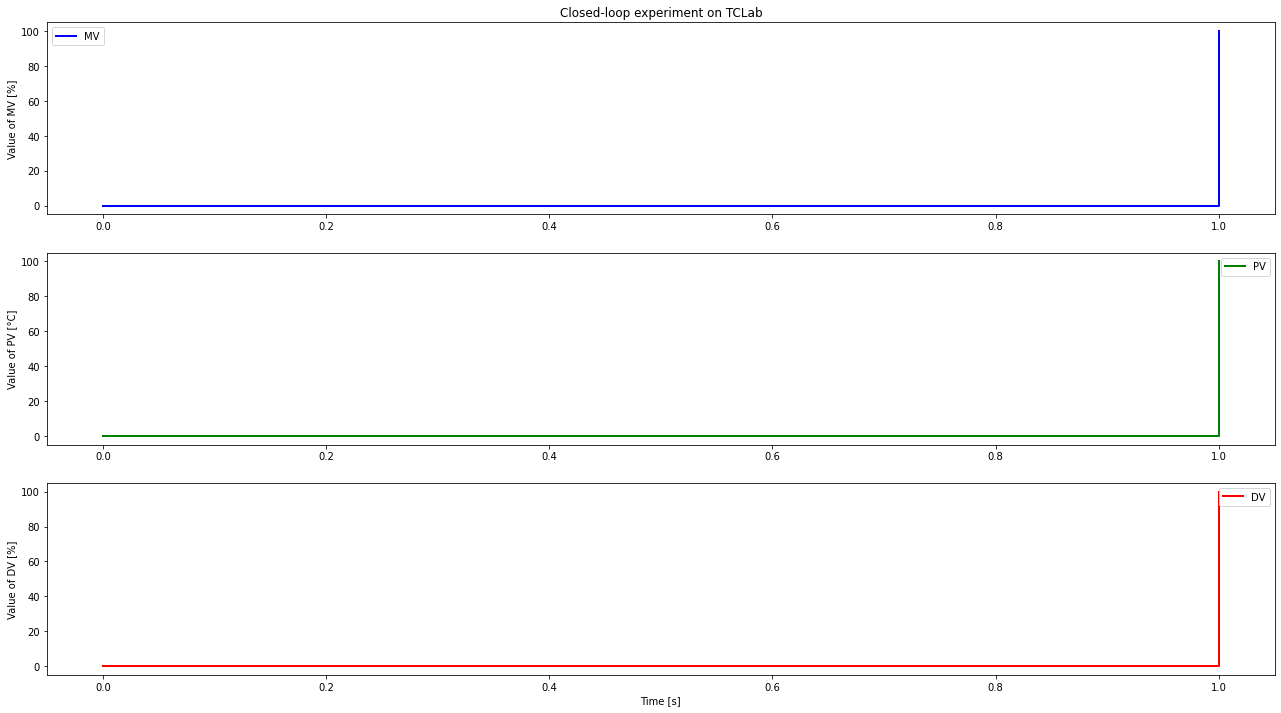

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Closed-loop experiment on TCLab')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

lab = tclab.TCLab()

t = []
i = 0
MV = []
DV = []
PV = []

Control()